In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms


# Get the MNIST dataset

In [46]:
train_mnist = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transforms.ToTensor())
test_mnist = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
val_mnist = torch.utils.data.Subset(train_mnist, range(50000, 60000))

In [47]:
len(train_mnist)

60000

In [48]:
len(val_mnist)

10000

In [49]:
len(test_mnist)

10000

In [50]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

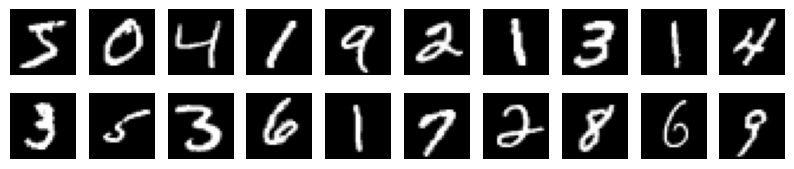

In [51]:
fig, ax = plt.subplots(2, 10, figsize=(10, 2))

for i in range(10):
    ax[0, i].imshow(train_mnist[i][0].squeeze(), cmap='gray')
    ax[1, i].imshow(train_mnist[i+10][0].squeeze(), cmap='gray')
    ax[1, i].axis('off')
    ax[0, i].axis('off')


Create a DataLoader

In [52]:
train_data_loader = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_mnist, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_mnist, batch_size=32, shuffle=True)

# Simple Neural Network

In [53]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Due to CrossEntropyLoss, we do not need apply softmax
        return x
    
# Initialize the model
simple_net = SimpleNet()

In [54]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device='cpu'):

    train_loss = {}
    val_loss = {}

    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(train_loader)
        train_loss[f'Epoch {epoch}'] = training_loss

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)
        val_loss[f'Epoch {epoch}'] = valid_loss

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))   

    return train_loss, val_loss

In [55]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_net.parameters(), lr=0.001)

In [56]:
train_loss, val_loss = train(simple_net, optimizer, loss, train_data_loader, val_data_loader, epochs=100)

Epoch: 0, Training Loss: 0.25, Validation Loss: 0.09, accuracy = 0.97
Epoch: 1, Training Loss: 0.10, Validation Loss: 0.06, accuracy = 0.98
Epoch: 2, Training Loss: 0.07, Validation Loss: 0.04, accuracy = 0.99
Epoch: 3, Training Loss: 0.05, Validation Loss: 0.04, accuracy = 0.99
Epoch: 4, Training Loss: 0.04, Validation Loss: 0.05, accuracy = 0.98
Epoch: 5, Training Loss: 0.04, Validation Loss: 0.02, accuracy = 0.99
Epoch: 6, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 7, Training Loss: 0.02, Validation Loss: 0.02, accuracy = 0.99
Epoch: 8, Training Loss: 0.02, Validation Loss: 0.02, accuracy = 0.99
Epoch: 9, Training Loss: 0.02, Validation Loss: 0.01, accuracy = 1.00
Epoch: 10, Training Loss: 0.02, Validation Loss: 0.01, accuracy = 1.00
Epoch: 11, Training Loss: 0.02, Validation Loss: 0.01, accuracy = 1.00
Epoch: 12, Training Loss: 0.02, Validation Loss: 0.01, accuracy = 1.00
Epoch: 13, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 1.00
Epoch: 14, Train

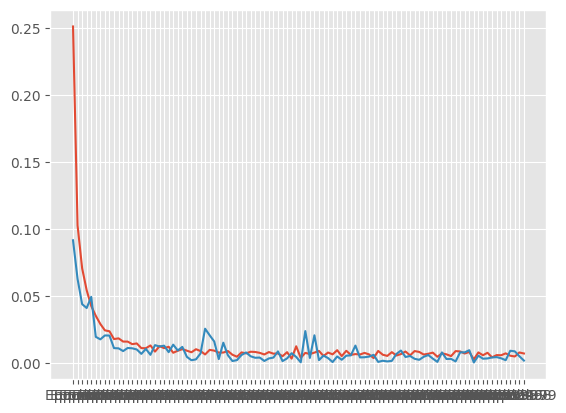

In [57]:
plt.plot(list(train_loss.keys()), list(train_loss.values()), label='Training Loss')
plt.plot(list(val_loss.keys()), list(val_loss.values()), label='Validation Loss')

In [62]:
# Test on test set

num_correct = 0

simple_net.eval()
for batch in test_data_loader:
    inputs, targets = batch
    output = simple_net(inputs)
    correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
    num_correct += torch.sum(correct).item()

print('Test accuracy: {:.2f}'.format(num_correct / len(test_mnist)))

Test accuracy: 0.98


In [63]:
# take random 10 samples from test-set
samples = torch.utils.data.Subset(test_mnist, range(10))

In [69]:
sample_loader = torch.utils.data.DataLoader(samples, batch_size=10)

for batch in sample_loader:
    inputs, targets = batch
    output = simple_net(inputs)
    result =  torch.argmax(F.softmax(output, dim=1), dim=1)

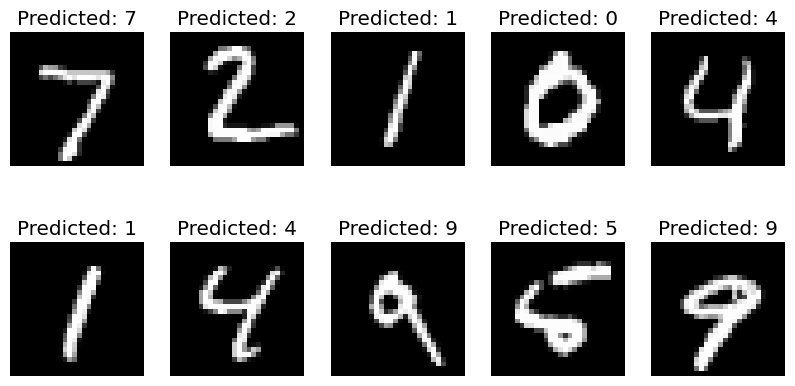

In [71]:
# Plot image and results
fig, ax = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    ax[0, i].imshow(samples[i][0].squeeze(), cmap='gray')
    ax[1, i].imshow(samples[i+5][0].squeeze(), cmap='gray')
    ax[1, i].axis('off')
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Predicted: {result[i]}')
    ax[1, i].set_title(f'Predicted: {result[i+5]}')

In [ ]:
torch.data.utils.RandomSampler(train_mnist)

# Convolutional Neural Network

In [72]:

class CNN_net(nn.Module):
    def __init__(self):
        super(CNN_net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [73]:
# Initialize the CNN model
cnn_net = CNN_net()

# Initialize the loss function
loss = nn.CrossEntropyLoss()

# Initialize the optimizer
optimizer = optim.Adam(cnn_net.parameters(), lr=0.001)

In [74]:
# Train the CNN model
train_loss, val_loss = train(cnn_net, optimizer, loss, train_data_loader, val_data_loader, epochs=5)

Epoch: 0, Training Loss: 0.16, Validation Loss: 0.04, accuracy = 0.99
Epoch: 1, Training Loss: 0.06, Validation Loss: 0.03, accuracy = 0.99
Epoch: 2, Training Loss: 0.04, Validation Loss: 0.03, accuracy = 0.99
Epoch: 3, Training Loss: 0.04, Validation Loss: 0.02, accuracy = 0.99
Epoch: 4, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 1.00


In [76]:
# Test on test set
num_correct = 0

simple_net.eval()
for batch in test_data_loader:
    inputs, targets = batch
    output = cnn_net(inputs)
    correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
    num_correct += torch.sum(correct).item()

print('Test accuracy: {:.2f}'.format(num_correct / len(test_mnist)))

Test accuracy: 0.99


In [77]:
sample_loader = torch.utils.data.DataLoader(samples, batch_size=10)

for batch in sample_loader:
    inputs, targets = batch
    output = simple_net(inputs)
    result =  torch.argmax(F.softmax(output, dim=1), dim=1)

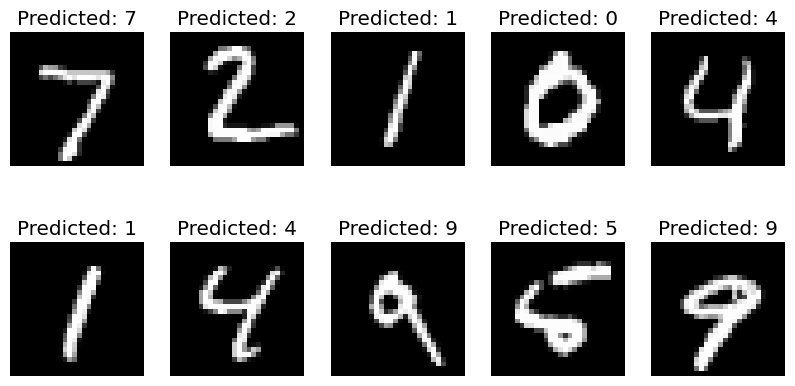

In [78]:
# Plot image and results
fig, ax = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    ax[0, i].imshow(samples[i][0].squeeze(), cmap='gray')
    ax[1, i].imshow(samples[i+5][0].squeeze(), cmap='gray')
    ax[1, i].axis('off')
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Predicted: {result[i]}')
    ax[1, i].set_title(f'Predicted: {result[i+5]}')